<h1>Short Term Rental Daily Rates</h1>
<br />
<p>This notebook creates a regression model to predict daily rental rate based on various features of a property and then saves it as pickle file for reuse. The model is based on about 29,000 records of short term rental rates for a single zip code that was downloaded from the website AllTheRooms (via personal paid subscription).</p>
<h4>Disclaimer:</h4>
<p>AllTheRooms requires a paid subscription in order to download raw data. You will need to have your own subscription to use this model as-is or you'll need to modify it to use with your data sources.</p>
<br/>

In [1]:
# Import all needed libraries

import pandas as pd
import numpy as np
import joblib
import glob
import csv
import os

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
%matplotlib inline

<br />
<p>Each CSV file can only hold 1000 records due to the website limitations. The next snippet will merge them all. The rates are also separate from the property details so they need to be joined later via UID.</p>
<br />

In [2]:
# Prep for merging airbnb details (studios, 2/2, 5bed, 5/4)
joined_files = os.path.join("AllTheRoomsData/", "*details.csv")
joined_stats = os.path.join("AllTheRoomsData/", "*stats.csv")

joined_list = glob.glob(joined_files)
joined_stats = glob.glob(joined_stats)

# Merge the files and verify
df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)
df.head()

,UID,Listing URL,Listing Title,Property Type,Arrangement Type,Longitude,Latitude,City,Currency Local,Bedrooms,Bathrooms,Max Guests,Overall Rating,Pets Allowed,Amenities,Security Deposit (USD),Created Date,Number of Reviews,Number of Photos
0,12382448,https://www.airbnb.com/rooms/12382448,"Lovely 2/2, WATER PARK! 2mi to Disney, Sanitized!",condo,Entire Home,-81.59376,28.32352,NaN,NaN,2,2,6,100.0,No,"24 hour check in,air conditioning,cable tv,chi...",100.0,2016-07-09,174,54
1,12433858,https://www.airbnb.com/rooms/12433858,REMODELED Windsor Hills Condo 2 Miles 2 Disney,condo,Entire Home,-81.59296,28.32437,NaN,NaN,2,2,6,100.0,No,"24 hour check in,air conditioning,bathtub,cabl...",200.0,2016-07-09,39,62
2,12812645,https://www.airbnb.com/rooms/12812645,Westgate Town Center sleeps 8pp,apartment,Entire Home,-81.59498,28.32955,NaN,NaN,2,2,8,NaN,No,"air conditioning,dryer,elevator,essentials,fam...",NaN,2016-07-11,1,33
3,13623622,https://www.airbnb.com/rooms/13623622,2 Bedroom Villa Available for Rent! Floating Unit,villa,Entire Home,-81.59512,28.33150,NaN,NaN,2,2,8,NaN,No,"air conditioning,cable tv,dryer,essentials,fam...",100.0,2016-07-09,1,5
4,14121078,https://www.airbnb.com/rooms/14121078,3 mi to Disney!*Spacious 2BR/2BA+Loft Resort C...,condo,Entire Home,-81.48591,28.33744,NaN,NaN,2,2,6,100.0,No,"24 hour check in,air conditioning,bathtub,bedr...",0.0,2016-07-21,118,66


<br />
<p>The amenities are listed as a comma separated string value. We need to do some feature engineering by parsing these values and then adding them as columns to the dataframe.</p>
<br />

In [3]:
#Parse through amenities and create a list of values to add as features
amenity_ls_str = ""
for prop_amenities in df["Amenities"]:
    ls = prop_amenities.split(",")
    for i in ls:
        amenity_ls_str = amenity_ls_str + "," + i

amenity_ls = (list(set(amenity_ls_str.split(","))))
amenity_ls.remove("")

#Verify amenity list to ensure no nulls or duplicates
print(amenity_ls)

['ice machine', 'sports court', 'parking', 'coffee', 'hot tub', 'bathroom essentials', 'shampoo', 'pet friendly', 'air conditioning', 'wheelchair friendly', 'smoke alarm', 'safety', 'patio or balcony', 'garden', 'child essentials', 'microwave', 'cleanliness', 'hangers', 'books', 'dishwasher', 'fans', 'bedroom essentials', 'easy access', 'dining space', 'kitchen', 'living area', 'fireplace', 'dryer', 'first aid kit', '24 hour check in', 'heating', 'elevator', 'fridge', 'hot water', 'fitness and wellbeing', 'lock on bedroom door', 'pool', 'smoking allowed', 'essentials', 'water sports', 'netflix', 'blender', 'breakfast included', 'family friendly', 'fire extinguisher', 'workspace', 'video game console', 'laundry', 'host greets you', 'bikes', 'music', 'long term stays', 'tv', 'private bathroom', 'wifi', 'cleaning included', 'ironing', 'beach essentials', 'cable tv', 'ski friendly', 'bbq', 'luggage dropoff', 'sauna', 'in home entertainment', 'hairdryer', 'events allowed', 'garbage disposal

In [4]:
# Suppress warnings about updating a dataframe based on a slice of data
pd.options.mode.chained_assignment = None  # default='warn'

# Add amenity list as columns to property details dataframe
#for a in amenity_ls:
#    df[a] = np.nan

# If value in amenities column set new column value to 1, it not set value to 0
for a in amenity_ls:
    df[a] = np.nan
    df[a].loc[df["Amenities"].str.contains(a)] = True
    df[a].loc[df[a].isnull()] = False
    
#for a in amenity_ls:
    #df[a].loc[df[a].isnull()] = False

# Print distribution of values across amenities
print("-- Amenity Values --")
for a in amenity_ls:
    print(a + " - True: " + str(df[a].loc[df[a] == True].size) + " vs False: " + str(df[a].loc[df[a] == False].size))

-- Amenity Values --
ice machine - True: 1 vs False: 3403
sports court - True: 3 vs False: 3401
parking - True: 3277 vs False: 127
coffee - True: 2254 vs False: 1150
hot tub - True: 1853 vs False: 1551
bathroom essentials - True: 47 vs False: 3357
shampoo - True: 1940 vs False: 1464
pet friendly - True: 353 vs False: 3051
air conditioning - True: 3272 vs False: 132
wheelchair friendly - True: 420 vs False: 2984
smoke alarm - True: 3177 vs False: 227
safety - True: 2679 vs False: 725
patio or balcony - True: 1879 vs False: 1525
garden - True: 1072 vs False: 2332
child essentials - True: 1585 vs False: 1819
microwave - True: 2304 vs False: 1100
cleanliness - True: 13 vs False: 3391
hangers - True: 2744 vs False: 660
books - True: 105 vs False: 3299
dishwasher - True: 2138 vs False: 1266
fans - True: 623 vs False: 2781
bedroom essentials - True: 1872 vs False: 1532
easy access - True: 53 vs False: 3351
dining space - True: 986 vs False: 2418
kitchen - True: 3247 vs False: 157
living area 

<br />
<p>Now that we have all our amenities added to a single dataframe of property details we need to remove irrelevant information that won't help the model. For example, since we know our data is for a single zip code, location data doesn't mean much. We can also reasonably expect that all properties will offer air conditioning or hot water so no need to include those features.</p>
<p>We also need to make certain assumptions for null data: we will assume an "average" user rating for all properties with no official rating and a zero dollar security deposit where none exists in the data.</p>
<br />

In [5]:
# Drop columns that don't make sense for this model or where values don't change
df_lesscolumns = df.drop(columns=["Listing Title", "Arrangement Type", "Longitude", "Latitude", "City", "Currency Local", "Amenities", "Created Date","air conditioning","cleanliness","coffee","hangers","heating","hot water","fans","books","blender","microwave","smoke alarm","ironing","lock on bedroom door","safety","music","garbage disposal","ice machine","shampoo","private bathroom"])

# Impute average rating for null ratings and 0 for null security deposits
meanrating = df_lesscolumns["Overall Rating"].mean()
values = {"Overall Rating": meanrating, "Security Deposit (USD)": 0}
df_clean = df_lesscolumns.fillna(value=values)

df_clean.head()

,UID,Listing URL,Property Type,Bedrooms,Bathrooms,Max Guests,Overall Rating,Pets Allowed,Security Deposit (USD),Number of Reviews,...,bbq,luggage dropoff,sauna,in home entertainment,hairdryer,events allowed,waterfront,kitchen essentials,bathtub,outdoor seating
0,12382448,https://www.airbnb.com/rooms/12382448,condo,2,2,6,100.000000,No,100.0,174,...,False,False,False,False,True,False,False,True,False,False
1,12433858,https://www.airbnb.com/rooms/12433858,condo,2,2,6,100.000000,No,200.0,39,...,False,False,False,False,True,False,False,True,True,False
2,12812645,https://www.airbnb.com/rooms/12812645,apartment,2,2,8,94.646414,No,0.0,1,...,False,False,False,False,True,False,False,False,False,False
3,13623622,https://www.airbnb.com/rooms/13623622,villa,2,2,8,94.646414,No,100.0,1,...,False,False,False,False,True,False,False,False,False,False
4,14121078,https://www.airbnb.com/rooms/14121078,condo,2,2,6,100.000000,No,0.0,118,...,False,False,False,False,True,False,False,True,True,False


<br />
<p>Now we will build a single dataframe by combining our property details with our daily rental rates data. Our rates CSV file has an average rate for each month of the year per property but we want a single average in order to join with our other dataframe so we will need to do some math. We will also create some new features based on the occupancy data.</p>
<p>We end up with a single dataframe that we will call rentals_final.</p>
<br />

In [6]:
# Start building rental rates dataframe
df_stats = pd.concat(map(pd.read_csv, joined_stats), ignore_index=True)

#Drop rows with nulls
df_stats_clean = df_stats.dropna(axis=0)

# Combine the property performance stats with the property details
rentals = df_stats_clean.merge(df_clean, how="inner", on="UID")

# Add features for month and year based on MONTH feature
rentals.insert(1, "Month", np.nan)
rentals.insert(2, "Year", np.nan)
for dt in rentals["MONTH (date)"].unique():
    rentals.loc[rentals["MONTH (date)"] == dt, "Year"] = dt.split("-")[0].replace(" ","")
    rentals.loc[rentals["MONTH (date)"] == dt, "Month"] = dt.split("-")[1].replace(" ","")

dfColumns = ""
print("---Rentals Dataframe Columns---")
for col in rentals.columns:
    if dfColumns == "":
        dfColumns = col
    else:
        dfColumns = dfColumns + ", " + col
print(dfColumns)

print("")

dfNulls = 0
print("-- Nulls in Rentals --")
for c in rentals.columns:
    if rentals[c].isnull().sum() > 0:
        dfNulls += rentals[c].isnull().sum()
        print(c + ": " + str(rentals[c].isnull().sum()))
if dfNulls == 0:
    print("No nulls in any column...")

---Rentals Dataframe Columns---
UID, Month, Year, Listing_URL, PROVIDER, MONTH (date), IS_ACTIVE, ADR, NIGHTS_BOOKED, NIGHTS_AVAILABLE, BOOKING_COUNT, AVG_LENGTH_OF_STAY, Listing URL, Property Type, Bedrooms, Bathrooms, Max Guests, Overall Rating, Pets Allowed, Security Deposit (USD), Number of Reviews, Number of Photos, sports court, parking, hot tub, bathroom essentials, pet friendly, wheelchair friendly, patio or balcony, garden, child essentials, dishwasher, bedroom essentials, easy access, dining space, kitchen, living area, fireplace, dryer, first aid kit, 24 hour check in, elevator, fridge, fitness and wellbeing, pool, smoking allowed, essentials, water sports, netflix, breakfast included, family friendly, fire extinguisher, workspace, video game console, laundry, host greets you, bikes, long term stays, tv, wifi, cleaning included, beach essentials, cable tv, ski friendly, bbq, luggage dropoff, sauna, in home entertainment, hairdryer, events allowed, waterfront, kitchen essenti

In [7]:
#Drop columns
rentals.drop(columns=["Listing_URL", "PROVIDER", "MONTH (date)", "IS_ACTIVE", "Listing URL"], inplace=True)

rentals.sample(n=10)

,UID,Month,Year,ADR,NIGHTS_BOOKED,NIGHTS_AVAILABLE,BOOKING_COUNT,AVG_LENGTH_OF_STAY,Property Type,Bedrooms,...,bbq,luggage dropoff,sauna,in home entertainment,hairdryer,events allowed,waterfront,kitchen essentials,bathtub,outdoor seating
16557,12433858,05,2019,115.0,14,19,1,9.0,condo,2,...,False,False,False,False,True,False,False,True,True,False
29875,24539386,07,2020,245.0,13,21,3,4.0,villa,6,...,True,False,False,False,True,False,False,True,False,True
1684,37538709,07,2021,168.0,13,14,3,3.0,townhouse,2,...,True,True,False,True,True,False,False,True,True,False
27676,38748391,08,2020,296.0,3,23,0,3.0,villa,8,...,False,False,False,False,True,True,False,True,False,False
4627,50044399,06,2021,177.0,2,4,1,2.0,apartment,2,...,False,False,False,False,True,False,False,True,False,False
20350,15008309,05,2019,301.0,9,19,2,4.0,house,6,...,True,True,False,False,True,False,False,True,True,True
25389,46299166,12,2020,315.0,4,4,1,4.0,house,5,...,False,False,True,False,True,False,False,True,True,False
2730,11210902,06,2019,143.0,6,18,1,6.0,condo,2,...,False,False,False,False,True,True,False,True,True,True
24317,33492510,05,2020,201.0,6,31,3,2.0,house,5,...,False,True,False,False,True,False,False,True,True,True
18081,33881582,01,2021,79.0,25,31,0,73.0,condo,2,...,True,False,False,False,False,False,False,True,True,False


In [8]:
# Remove outliers
q9 = rentals.ADR.quantile(0.9)
rentals_final = rentals.drop(rentals[rentals.ADR>q9].index)

rentals_final.describe()

,UID,ADR,NIGHTS_BOOKED,NIGHTS_AVAILABLE,BOOKING_COUNT,AVG_LENGTH_OF_STAY,Bedrooms,Bathrooms,Max Guests,Overall Rating,Security Deposit (USD),Number of Reviews,Number of Photos
count,2.879600e+04,28796.00000,28796.00000,28796.000000,28796.000000,28796.000000,28796.000000,28796.000000,28796.000000,28796.000000,28796.000000,28796.000000,28796.000000
mean,1.776984e+14,191.98472,14.26903,23.570774,2.309765,6.627344,4.025906,3.434401,9.687665,94.780117,248.558619,52.353799,42.042749
std,9.534709e+15,81.09590,8.15686,7.365465,1.945417,6.886009,1.959165,1.420866,3.609151,6.007056,432.011026,51.712829,19.390757
min,1.270590e+05,13.00000,1.00000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,40.000000,0.000000,0.000000,4.000000
25%,2.096888e+07,126.00000,7.00000,19.000000,1.000000,4.000000,2.000000,2.000000,6.000000,90.000000,0.000000,18.000000,28.000000
50%,3.223599e+07,179.00000,14.00000,26.000000,2.000000,5.000000,5.000000,4.000000,10.000000,100.000000,200.000000,37.000000,39.000000
75%,4.271645e+07,246.00000,21.00000,30.000000,3.000000,7.000000,5.000000,4.000000,12.000000,100.000000,350.000000,68.000000,52.000000
max,5.180076e+17,402.00000,31.00000,31.000000,19.000000,124.000000,10.000000,12.000000,21.000000,100.000000,5000.000000,380.000000,262.000000


<br />
<p>We finally have a single source of data that is clean! Now it's time to split up the data between training and test sets based on the features that we believe should affect the rental rate.</p>
<br />

In [9]:
# Split data for all rentals and different arrangement datasets
x, y = rentals_final[["Property Type","Bedrooms","Bathrooms","Max Guests","Overall Rating",
                      "Pets Allowed","Security Deposit (USD)","Number of Reviews","Number of Photos",
                      "NIGHTS_BOOKED","NIGHTS_AVAILABLE","patio or balcony","wifi","bikes","24 hour check in",
                      "garden","host greets you","family friendly","kitchen","smoking allowed",
                      "bathtub","dining space","sports court","sauna","tv",
                      "beach essentials","wheelchair friendly","cable tv","hot tub","long term stays",
                     "fridge","water sports","pool","child essentials","waterfront","easy access",
                      "ski friendly","workspace","laundry","dishwasher","luggage dropoff",
                      "pet friendly","parking","events allowed","outdoor seating","breakfast included",
                      "cleaning included","in home entertainment","elevator","bedroom essentials",
                      "bbq","netflix","essentials","kitchen essentials","bathroom essentials",
                     "fitness and wellbeing","living area","video game console","fireplace",
                     "BOOKING_COUNT", "AVG_LENGTH_OF_STAY", "Month"]].values, rentals_final["ADR"].values

# Split data 70%-30% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (x_train.shape[0], x_test.shape[0]))

Training Set: 20157 rows
Test Set: 8639 rows


<br />
<p>We need to do some preprocessing of our features to help the model. Property Type needs to be Hot Encoded and the others need to be scaled (normalized) or Ordinal Encoded.</p>
<p>We then build a training pipeline with a GradientBoostingRegressor, fit the data, and output our metrics.</p>
<br />

MSE: 1956.17800828625
RMSE: 44.22870118244769
R2: 0.6995527547073047
R2 Adjusted: 0.697380678073892


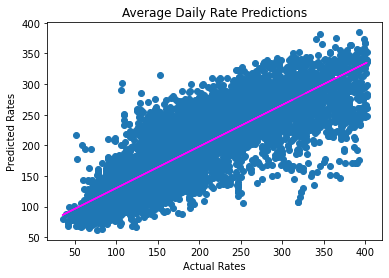

In [18]:
# PreProcess and Train a model
# Define preprocessing for numeric columns (scale them)
numeric_features = [1,2,3,4,6,7,8,9,10,59,60,61]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
# Ordinal encode True/False columns and Hot encode Property Type
categorical_features_hotencode = [0]
categorical_transformer_hotencode = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_features_ordinal = [5,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,
                               30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
                               50,51,52,53,54,55,56,57,58]
categorical_transformer_ordinal = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=3))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer_hotencode, categorical_features_hotencode),
        ('cat2', categorical_transformer_ordinal, categorical_features_ordinal)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])

# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(x_train, (y_train))

# Get predictions
predictions = model.predict(x_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
r2adjusted = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
print("R2 Adjusted:", r2adjusted)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Rates')
plt.ylabel('Predicted Rates')
plt.title('Average Daily Rate Predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

<br />
<p>70% R2 and R2 adjusted score is not bad. We'll go ahead and save the model as a pickle file for reuse.</p>
<br />

In [11]:
# Save the model as a pickle file
filename = './rentals.pkl'
joblib.dump(model, filename)

['./rentals.pkl']

<br />
<p>Now that we have a pickle file, we are going to load it and predict a price for two different properties. One will have the majority of the values randomly generated and the other will be a more realistic home with only the amenities randomly generated.</p>
<br />

In [55]:
xData = ["patio or balcony","wifi","bikes","24 hour check in",
"garden","host greets you","family friendly","kitchen","smoking allowed",
"bathtub","dining space","sports court","sauna","tv",
"beach essentials","wheelchair friendly","cable tv","hot tub","long term stays",
"fridge","water sports","pool","child essentials","waterfront","easy access",
"ski friendly","workspace","laundry","dishwasher","luggage dropoff",
"pet friendly","parking","events allowed","outdoor seating","breakfast included",
"cleaning included","in home entertainment","elevator","bedroom essentials",
"bbq","netflix","essentials","kitchen essentials","bathroom essentials",
"fitness and wellbeing","living area","video game console","fireplace"]

# Test my model with fake property using mostly randomly generated values
import random as r
mymodel = joblib.load("rentals.pkl")

prop = [r.choice(["studio","condo","villa","townhouse","house"]),
        r.randint(1,6),r.randint(1,4),r.randint(1,12),r.randint(0,100),
        r.choice([True, False]),0,r.randint(0,1000),r.randint(0,10),
        15,30]

prop2 = ["house",4,2,8,100,True,0,100,7,15,30]

for f in xData:
    prop = np.append(prop, r.choice([True, False]))
    prop2 = np.append(prop2, r.choice([True, False]))

prop = np.append(prop, [5,6,r.randint(1,12)])
prop2 = np.append(prop2, [5,6,prop[61]])

props = [prop, prop2]
result = mymodel.predict(props)

print("Recommended Daily Rental Rate for the Month {}:" .format(props[0][61]))
print(str(props[0][1]) + "/" + str(props[0][2]) + " " + props[0][0] + " - ${}" .format(np.round(result[0])))
print(str(props[1][1]) + "/" + str(props[1][2]) + " " + props[1][0] + " - ${}" .format(np.round(result[1])))

Recommended Daily Rental Rate for the Month 1:
4/2 villa - $148.0
4/2 house - $131.0


<br />
<h2>Conclusion</h2>
<br />
<p>As you can see, the model provides a price prediction based on the property features and month of the year. You can continue to run the randomly generated prediction until you find a realistic random property or simply remove the random generator and input your own property features.</p>
<br />